### Переходим к практике

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

Наши новости

In [3]:
news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Web_2/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [5]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Web_2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [11]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [12]:
pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 8.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a779a68c03254a2e1b525454b6284fe2fed1dcd2a8274c7d80bfd7137f2885db
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [16]:
#предобработка текст
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel


import pymorphy2  # pip install pymorphy2

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [23]:
with open('/content/drive/MyDrive/Colab Notebooks/Web_2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [24]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [25]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 29.1 s, sys: 1.41 s, total: 30.5 s
Wall time: 33.2 s


In [26]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 13s, sys: 812 ms, total: 4min 14s
Wall time: 4min 17s


А теперь в 3 строчки обучим нашу модель

In [27]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [28]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [29]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 48.6 s, sys: 23 s, total: 1min 11s
Wall time: 46.3 s


In [30]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [31]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.6275972), (1, 0.09636305), (11, 0.25457636)]

In [32]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: всё население смерть риск например очень день
topic_1: гражданин мозг убийство задержать сотрудник ссср армия
topic_2: россия рынок млрд путин экономический всё цена
topic_3: банк журнал статья космос медведев nn взрыв
topic_4: наука погибнуть станция статья nn журнал опубликовать
topic_5: руб млн тыс цена стоимость сумма доход
topic_6: россия российский проект фонд эксперт регион программа
topic_7: произойти самолёт данные пациент район пассажир пострадать
topic_8: книга ветер лёд геном первый nn перевод
topic_9: рост средство выяснить россия случай правительство документ
topic_10: считаться увидеть музей известный жизнь белок первый
topic_11: млрд температура составить налог млн активность затмение
topic_12: исследование учёный болезнь лаборатория спрос ес список
topic_13: поверхность северный китай китайский ген японский южный
topic_14: операция экономика сша американский около месяц безопасность
topic_15: энергия поиск источник изучение гражданин сотрудник способность
topi

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [33]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [34]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.070648,0.000000,0.0,0.619430,0.000000,0.0,0.264677,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.038187,0.0,0.0,0.000000
1,4896,0.000000,0.000000,0.0,0.444208,0.352930,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.181398,0.0,0.000000,0.0,0.0,0.000000
2,4897,0.627637,0.096365,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,4898,0.329817,0.000000,0.0,0.468433,0.087217,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.083934,0.0,0.000000,0.0,0.0,0.021076
4,4899,0.000000,0.000000,0.0,0.000000,0.081875,0.0,0.859013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [35]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [36]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [37]:
doc_dict[293622]

array([0.05096037, 0.        , 0.07230294, 0.        , 0.        ,
       0.05662044, 0.02562484, 0.        , 0.02301209, 0.        ,
       0.28253344, 0.        , 0.04359968, 0.        , 0.        ,
       0.09923333, 0.        , 0.04283953, 0.        , 0.03157093,
       0.        , 0.        , 0.04621864, 0.2198924 , 0.        ])

In [38]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [39]:
get_user_embedding(user_articles_list)

array([0.03313327, 0.10608621, 0.09790022, 0.04084913, 0.01700382,
       0.        , 0.12981033, 0.        , 0.00767153, 0.05502281,
       0.        , 0.        , 0.019853  , 0.00188793, 0.04967183,
       0.00210854, 0.02487512, 0.12071937, 0.05104595, 0.        ,
       0.0882781 , 0.05940961, 0.0306729 , 0.04680509, 0.00784498])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [40]:
#users['articles'].iloc[33]

In [41]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [42]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.016161,0.019165,0.025574,0.008601,0.050003,0.072156,0.033231,0.040019,0.003835,...,0.021627,0.012354,0.104270,0.000000,0.016266,0.002975,0.179253,0.04079,0.096432,0.057912
1,u108690,0.095373,0.070780,0.121975,0.031322,0.085296,0.021396,0.034423,0.038565,0.002171,...,0.015583,0.005592,0.078676,0.036607,0.000000,0.008155,0.100845,0.00000,0.056382,0.022042
2,u108339,0.047159,0.088838,0.041969,0.025932,0.091353,0.003992,0.057221,0.125575,0.003378,...,0.013143,0.029258,0.157093,0.017094,0.022320,0.014730,0.035925,0.02227,0.069413,0.003702


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [44]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Web_2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [45]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.016161,0.019165,0.025574,0.008601,0.050003,0.072156,0.033231,0.040019,0.003835,...,0.012354,0.104270,0.000000,0.016266,0.002975,0.179253,0.04079,0.096432,0.057912,0
1,u108690,0.095373,0.070780,0.121975,0.031322,0.085296,0.021396,0.034423,0.038565,0.002171,...,0.005592,0.078676,0.036607,0.000000,0.008155,0.100845,0.00000,0.056382,0.022042,1
2,u108339,0.047159,0.088838,0.041969,0.025932,0.091353,0.003992,0.057221,0.125575,0.003378,...,0.029258,0.157093,0.017094,0.022320,0.014730,0.035925,0.02227,0.069413,0.003702,1


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [47]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [48]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [49]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.20388812, 0.0258576 , 0.41554493, 0.15674624, 0.06826926,
       0.02898527, 0.31661599, 0.06992288, 0.12580542, 0.14661375])

In [50]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
precision_median, recall_median, fscore_median = precision[ix], recall[ix], fscore[ix]

In [52]:
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.238065, F-Score=0.653, Precision=0.591, Recall=0.731


In [53]:
roc_auc_score_median = roc_auc_score(y_test, preds)

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
import itertools

Confusion matrix, without normalization
[[1631  124]
 [  67  178]]


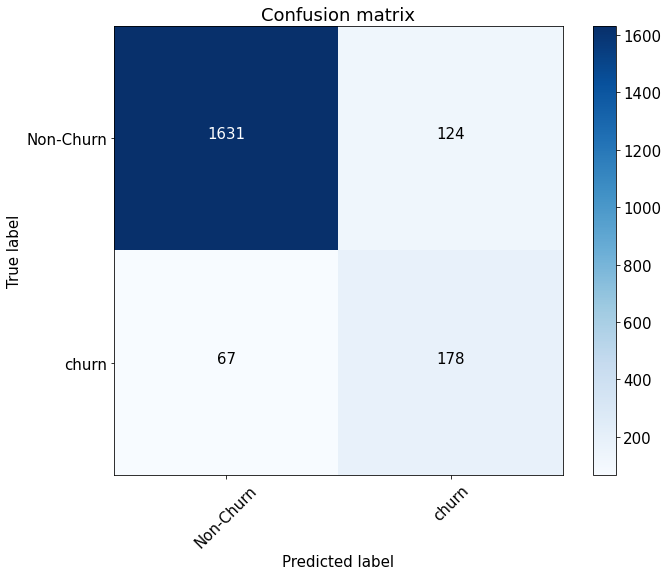

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [57]:
roc_auc_score(y_test, preds)

0.9330193615907901

### Среднее значение

In [58]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [59]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [62]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Web_2/users_churn.csv")

In [63]:
X = pd.merge(user_embeddings, target, 'left')

In [64]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [65]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [66]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.20388812, 0.0258576 , 0.41554493, 0.15674624, 0.06826926,
       0.02898527, 0.31661599, 0.06992288, 0.12580542, 0.14661375])

#### Рассчитаем Precision, Recall, F_score

In [67]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
precision_mean, recall_mean, fscore_mean = precision[ix], recall[ix], fscore[ix]

In [68]:
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.238065, F-Score=0.653, Precision=0.591, Recall=0.731


In [70]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
roc_auc_score_mean

0.9330193615907901

### Медиана

In [71]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [72]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [74]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Web_2/users_churn.csv")

In [75]:
X = pd.merge(user_embeddings, target, 'left')

In [76]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [77]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [78]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06889188, 0.01949887, 0.32169595, 0.11635796, 0.05878186,
       0.0506598 , 0.4764258 , 0.03867376, 0.0603977 , 0.1497018 ])

#### Рассчитаем Precision, Recall, F_score

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
precision_median, recall_median, fscore_median = precision[ix], recall[ix], fscore[ix]

In [80]:
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.230858, F-Score=0.756, Precision=0.704, Recall=0.816


In [82]:
roc_auc_score_median = roc_auc_score(y_test, preds)
roc_auc_score_median

0.9724216524216525

Из расчетов видно что медиана более точно помогает обучить модель за счет того что более комфортно работает с выбросами.

### Максимальное значение

In [ ]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [ ]:
target = pd.read_csv("users_churn.csv")

In [ ]:
X = pd.merge(user_embeddings, target, 'left')

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02566456, 0.00290468, 0.6134426 , 0.16619688, 0.03616941,
       0.01232761, 0.0654027 , 0.02460259, 0.13068745, 0.46411836])

#### Рассчитаем Precision, Recall, F_score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
precision_max, recall_max, fscore_max = precision[ix], recall[ix], fscore[ix]

In [ ]:

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.308975, F-Score=0.768, Precision=0.725, Recall=0.816


In [ ]:
roc_auc_score_max = roc_auc_score(y_test, preds)

#### Сводная таблица результатов

In [ ]:
table = pd.DataFrame(data={'Metrics':['Precision', 'Recall', 'F-score', 'Roc_auc_score'],
                          'Mean':[precision_mean, recall_mean, fscore_mean, roc_auc_score_mean],
                          'Median':[precision_median, recall_median, fscore_median, roc_auc_score_median],
                          'Max':[precision_max, recall_max, fscore_max, roc_auc_score_max]}, dtype=np.float) 
table

C:\Users\gromo\AppData\Local\Temp\ipykernel_4548\1345582343.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'Max':[precision_max, recall_max, fscore_max, roc_auc_score_max]}, dtype=np.float)
C:\Users\gromo\AppData\Local\Temp\ipykernel_4548\1345582343.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  table = pd.DataFrame(data={'Metrics':['Precision', 'Recall', 'F-score', 'Roc_auc_score'],


,Metrics,Mean,Median,Max
0,Precision,0.621212,0.831224,0.724638
1,Recall,0.836735,0.804082,0.816327
2,F-score,0.713043,0.817427,0.767754
3,Roc_auc_score,0.958253,0.981206,0.965775


Мы видим что наибольшие значения Precision, Recall, F_score получаются при расчете медианы, как я помнь медиана более точно находит истиное среднее значение и соответственно более точно работает с выбросами, таким образом с помощью median можно более точно обучить модель)

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk